In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 5, 25), datetime.date(2022, 5, 23))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,chmt,2.475858
2,bxsl,2.249160
3,APSG,2.178348
4,dwin,1.886962


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=E">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'dov dvd dow tiki ret docs rdy dgnr dw drq ds dd napa dco dse duc '
    'dpg duk dukb dre dnb dft bros dy dt dyn dx dang ej etwo ect eggf '
    'semf eme e eog epam epr eqha eqm eqt esab ese esm gwh gems fedl '
    'esus ifed egif exp ecc eccw eccy eccx eccv eic este dea egp emn '
    'kodk etn eht exd ev eoi eos efl eff eft etx evn eot etj efr evf'
)
missing = (
    'ej dgnr duc dse dvd dang ev eff dw eqm eht egif tiki dft ect')
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [7]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  62 of 62 completed


,dov,dow,ret,docs,rdy,drq,ds,dd,napa,dco,...,eoi,eos,efl,eft,etx,evn,eot,etj,efr,evf
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-25,NaN,8.65,33.694500,NaN,NaN,NaN,31.687166,NaN,7.051511,9.629559,...,30.586538,NaN,NaN,NaN,NaN,NaN,NaN,28.283978,NaN,NaN
2012-05-29,NaN,8.83,34.426514,NaN,NaN,NaN,32.285461,NaN,7.157545,9.847138,...,31.814188,NaN,NaN,NaN,NaN,NaN,NaN,28.358751,NaN,NaN
2012-05-30,NaN,8.71,33.608372,NaN,NaN,NaN,31.778152,NaN,7.022961,9.545340,...,30.986237,NaN,NaN,NaN,NaN,NaN,NaN,27.872707,NaN,NaN
2012-05-31,NaN,9.03,33.436127,NaN,NaN,NaN,31.188129,NaN,6.986257,9.713781,...,30.548468,NaN,NaN,NaN,NaN,NaN,NaN,27.508175,NaN,NaN
2012-06-01,NaN,8.85,32.682568,NaN,NaN,NaN,30.151463,NaN,6.900609,9.411981,...,28.997255,NaN,NaN,NaN,NaN,NaN,NaN,27.293194,NaN,NaN


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])
    
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_68707/2417818282.py:8: RuntimeWarning: Mean of empty slice.
  sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  

,stock,sharpe
36,esus,0.914304
9,dco,0.813946
54,efl,0.799716
21,eggf,0.790537
34,gems,0.755905
28,eqha,0.716498
33,gwh,0.705327
6,ds,0.671397
46,dea,0.649781
30,esab,0.619436


In [11]:
sharpes = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes.head(20)

,stock,sharpe
0,ASAN,4.146624
1,chmt,2.475858
2,bxsl,2.249160
3,APSG,2.178348
4,dwin,1.886962
5,cc,1.678946
6,cm,1.621121
7,clt,1.521644
8,AZEK,1.491984
9,calx,1.477710


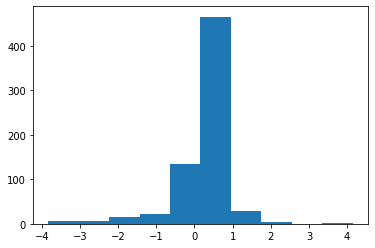

In [12]:
plt.hist(sharpes.sharpe);

In [13]:
sharpes.to_csv('sharpes.csv', index=False)

In [14]:
sharpes.shape

(690, 2)

In [15]:
MIX = sharpes.stock.tolist()[:200]
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
df.columns = MIX
MAX_MISSING = 250
n_nan = df.isnull().sum()
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

[*********************100%***********************]  200 of 200 completed
(2515, 111)


,ASAN,chmt,bxsl,cc,cm,AZEK,calx,bbw,ASL,dte,...,ANAC,cnc,eoi,ccrd,bsl,cpt,dhx,ACHR,dq,cee
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-25,31.475082,4.486716,17.602705,16.624710,7.216533,24.535305,2.819932,9.650220,14.092465,26.615728,...,29.110001,8.119740,18.619215,8.415731,8.887434,105.220001,69.872452,17.620646,113.967430,7.405140
2012-05-29,31.142420,4.545002,17.602705,16.893654,7.203523,24.725500,2.865838,9.722916,14.205259,26.782810,...,29.459999,8.131127,18.630816,8.375159,9.004554,107.190002,71.884308,17.775528,113.172310,7.441216
2012-05-30,31.432438,4.459028,17.230074,16.335844,7.177501,24.459229,2.800258,9.541179,13.831626,26.594833,...,28.139999,8.142516,18.567028,8.351976,8.887434,105.360001,68.634445,17.638863,110.256828,7.342006
2012-05-31,31.551851,4.498374,17.392088,16.226274,7.151481,24.253809,2.780584,9.613873,13.613083,26.810656,...,28.209999,8.279179,18.665606,8.369363,8.804758,104.849998,66.212952,17.575087,108.030502,7.292397
2012-06-01,30.946228,4.208391,16.582018,15.917486,7.090763,23.523457,2.596961,9.132272,13.084349,26.727112,...,27.330000,8.262093,18.375673,8.380954,8.749644,104.580002,65.895393,17.092203,106.069206,7.161611


In [16]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

cmcm  : 0.06025
ADM   : 0.00936
AVD   : 0.02124
cia   : 0.11145
dlx   : 0.21163
csv   : 0.00367
ce    : 0.05523
APO   : 0.18983
ra    : 0.00651
AFT   : 0.0435
sam   : 0.04507
cmsd  : 0.00971
ATIP  : 0.03185
ACHR  : 0.20072


In [17]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 24.8%
Annual volatility: 16.9%
Sharpe Ratio: 1.35


In [18]:
s1

1.348301431924718